# Single Character Network

The purpose of this network is to identify which alphanumeric value a CAPTCHA character and takes a centered 32x32 input.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import image_preprocess as img_pp
import os

# Automatically reload your external source code
%load_ext autoreload
%autoreload 2

In [2]:
#Extracting all centered single char images
y_pos = np.load('data/y_single_pos.npy')
y_label = np.load('data/y_single_label.npy')
x = np.load('data/x_single.npy')
centered_labels = y_label[np.nonzero(y_pos)]
centered_x = x[np.nonzero(y_pos)]

np.save("data/x_single_centered.npy", centered_x)
np.save("data/y_single_label_centered.npy", centered_labels)

print(f"Centered X samples: {centered_x.shape}")

Centered X samples: (11700, 32, 32, 3)


In [3]:
#Make sure at least one of these files exist
#Path to full data files created by Data Gen Notebook
X_PATH = "data/x_single_centered.npy"
Y_PATH = "data/y_single_label_centered.npy"

#Preprocessed and saved previously
X_PREPROCESSED = "data/x_single_centered_preprocessed.npy"
Y_PREPROCESSED = "data/y_single_label_centered_preprocessed.npy"

#Smaller data set for development
X_DEV = "data/x_single_dev.npy"
Y_DEV = "data/y_single_pos_dev.npy"

USE_DEV = False


if not os.path.exists(X_PREPROCESSED) and not os.path.exists(Y_PREPROCESSED):
    print("Preprocessing data, please wait...")
    x, y = img_pp.preprocess_image_data(X_PATH, Y_PATH)
    print(x.shape)
    print(y.shape)
    print("Preprocessed data saved to disk")
    
if not USE_DEV:
    print("Loading in preprocessed data")
    print("Creating Splits")
    x_train, x_val, x_test, x_train_dev, x_val_dev,  y_train, y_val, y_test, y_train_dev, y_val_dev =  img_pp.split(X_PREPROCESSED, Y_PREPROCESSED, test_split=100)

if USE_DEV:
    print("Loading in dev set")
    print("Creating splits")
    x_train, x_val, x_test, x_train_dev, x_val_dev, y_train, y_val, y_test, y_train_dev, y_val_dev =  img_pp.split(X_DEV, Y_DEV, test_split=100)
    
print(f"x_train shape: {x_train.shape}")
print(f"x_val shape: {x_val.shape}")

Preprocessing data, please wait...
(11700, 32, 32, 1)
(11700,)
Preprocessed data saved to disk
Loading in preprocessed data
Creating Splits
x_train shape: (9360, 32, 32, 1)
x_val shape: (2240, 32, 32, 1)


In [4]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(np.unique(y_label))

ind2char = {}
char2ind = {}
for i, char in enumerate(np.unique(y_label)):
    ind2char[i] = char
    char2ind[char] = i

y_train_ind = np.vectorize(char2ind.get)(y_train)
print(y_train[0:5])
print(y_train_ind[0:5])
y_val_dev_ind = np.vectorize(char2ind.get)(y_val_dev)


(9360, 32, 32, 1) (9360,)
(2240, 32, 32, 1) (2240,)
['3' '4' '5' '7' 'A' 'E' 'F' 'H' 'J' 'K' 'L' 'M' 'N' 'Q' 'R' 'S' 'T' 'X'
 'Y' 'a' 'd' 'f' 'h' 'i' 'j' 'k' 'p' 'r' 's' 't' 'w' 'x' 'y' 'z']
['p' 'N' 'N' 'k' 'Q']
[26 12 12 25 13]


In [7]:
from keras_tuner import Hyperband
from tensorflow import keras

def model_builder(hp):
    # single character recognition
    single = keras.Sequential()
    #CNN layer
    single.add(layers.Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=64, step=4),
                             kernel_size=hp.Choice('conv_1_kernel', values = [3,5]), 
                             activation='relu', input_shape=(32,32,1)))
    single.add(layers.MaxPooling2D((2, 2)))
    
    single.add(layers.Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=4), 
                            kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
                            activation='relu'))
    single.add(layers.MaxPooling2D((2, 2)))
    
    single.add(layers.Conv2D(64, (3, 3), activation='relu'))

    #Dense Layer
    single.add(layers.Flatten())
    single.add(layers.Dense(units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16), 
                            activation='relu'))
    single.add(layers.Dense(units = 34, activation = 'softmax')) 

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    single.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return single

#creating randomsearch object
tuners = Hyperband(model_builder,
                    objective='val_accuracy',
                    max_epochs = 50,
                    factor = 10,
                    project_name = 'singleCharTrials')


stopEarly = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuners.search(x_train, y_train_ind, epochs=50, validation_split=0.2, callbacks=[stopEarly])

# Get the optimal hyperparameters
best_hp=tuners.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of filters in the first convolution
layer is {best_hp.get('conv_1_filter')}. The optimal kernel size in the first convolutional layer is
{best_hp.get('conv_1_kernel')}. Optimal filters in the second convolutional layer is {best_hp.get("conv_2_filter")}
and kernel size is {best_hp.get("conv_2_kernel")}.

Dense layers {best_hp.get('dense_1_units')}

and the optimal learning rate for the optimizer
is {best_hp.get('learning_rate')}.
""")


INFO:tensorflow:Reloading Tuner from ./singleCharTrials/tuner0.json
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of filters in the first convolution
layer is 52. The optimal kernel size in the first convolutional layer is
5. Optimal filters in the second convolutional layer is 48
and kernel size is 5.

Dense layers 96

and the optimal learning rate for the optimizer
is 0.001.



In [8]:
# single character recognition
single = models.Sequential()
#CNN layer
single.add(layers.Conv2D(52, (5,5), activation='relu', input_shape=(32,32,1)))
single.add(layers.MaxPooling2D((2, 2)))
single.add(layers.Conv2D(48, (5, 5), activation='relu'))
single.add(layers.MaxPooling2D((2, 2)))
single.add(layers.Conv2D(64, (3, 3), activation='relu'))

#Dense Layer
single.add(layers.Flatten())
single.add(layers.Dense(96, activation='relu'))
single.add(layers.Dense(34, activation='softmax')) 
# change to total alphanumeric  unique values
# change cross entropy to 

single.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 52)        1352      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 52)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 48)        62448     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 48)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 64)          27712     
                                                                 
 flatten_1 (Flatten)         (None, 576)              

In [9]:
single.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


single_history = single.fit(x_train, y_train_ind, epochs=30, 
                    validation_data=(x_val_dev, y_val_dev_ind))

Epoch 1/30
293/293 [==============================] - 4s 12ms/step - loss: 2.6450 - accuracy: 0.2475 - val_loss: 1.6207 - val_accuracy: 0.5440
Epoch 2/30
293/293 [==============================] - 3s 12ms/step - loss: 1.2217 - accuracy: 0.6358 - val_loss: 0.9991 - val_accuracy: 0.7060
Epoch 3/30
293/293 [==============================] - 3s 12ms/step - loss: 0.8443 - accuracy: 0.7450 - val_loss: 0.7524 - val_accuracy: 0.7660
Epoch 4/30
293/293 [==============================] - 4s 12ms/step - loss: 0.6660 - accuracy: 0.7932 - val_loss: 0.6737 - val_accuracy: 0.7740
Epoch 5/30
293/293 [==============================] - 4s 12ms/step - loss: 0.5481 - accuracy: 0.8272 - val_loss: 0.6381 - val_accuracy: 0.7860
Epoch 6/30
293/293 [==============================] - 4s 12ms/step - loss: 0.4622 - accuracy: 0.8531 - val_loss: 0.5440 - val_accuracy: 0.8200
Epoch 7/30
293/293 [==============================] - 3s 12ms/step - loss: 0.3839 - accuracy: 0.8767 - val_loss: 0.4957 - val_accuracy: 0.8460

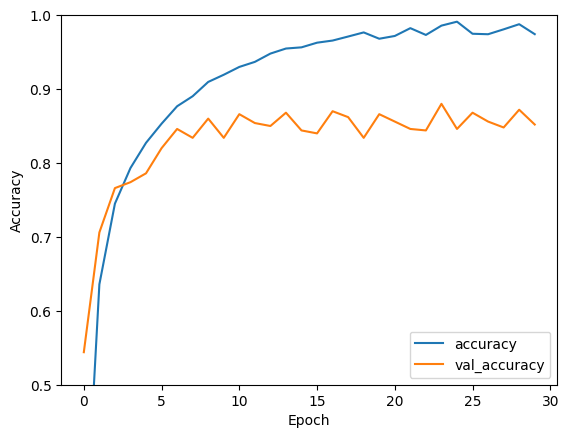

In [10]:
#Plotting Training Data
plt.plot(single_history.history['accuracy'], label='accuracy')
plt.plot(single_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


1/1 [==============================] - 0s 49ms/step
16
1/1 [==============================] - 0s 6ms/step
9
1/1 [==============================] - 0s 7ms/step
27
1/1 [==============================] - 0s 6ms/step
29
1/1 [==============================] - 0s 6ms/step
11
1/1 [==============================] - 0s 6ms/step
8
1/1 [==============================] - 0s 6ms/step
4
1/1 [==============================] - 0s 6ms/step
18
1/1 [==============================] - 0s 6ms/step
5
1/1 [==============================] - 0s 6ms/step
29
1/1 [==============================] - 0s 6ms/step
28
1/1 [==============================] - 0s 6ms/step
24
1/1 [==============================] - 0s 7ms/step
18
1/1 [==============================] - 0s 6ms/step
12
1/1 [==============================] - 0s 6ms/step
33
1/1 [==============================] - 0s 6ms/step
18
1/1 [==============================] - 0s 6ms/step
2
1/1 [==============================] - 0s 6ms/step
1
1/1 [============================

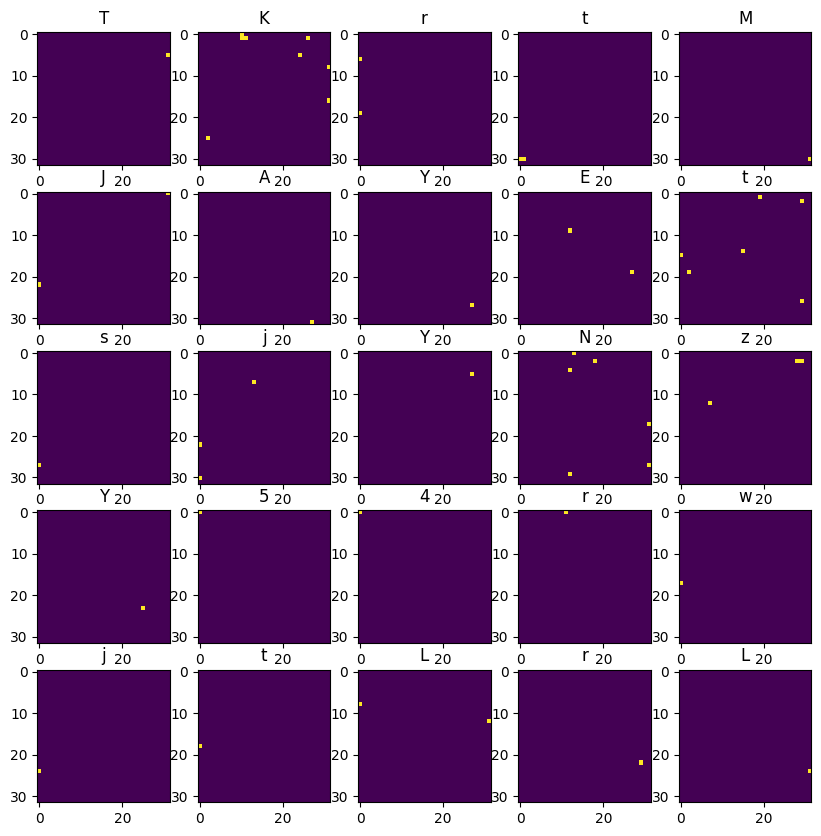

In [11]:
fig, axs = plt.subplots(5,5)
fig.set_size_inches(10,10)
N = x_train.shape[0]
for i in range(5):
    for j in range(5):
        idx = np.random.randint(0, N)
        axs[i,j].imshow(x_train[idx, :, :, :].astype(int))
        y = np.argmax(single.predict(np.squeeze(x_train[idx,:,:,:])[None, :, :, None]))
        print(y)
        title = ind2char[y]
        axs[i,j].set_title(title)
        axs[i,j].set_xticks = []
        axs[i,j].set_yticks = []
    
plt.show()